In [1]:
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(1)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
# une os conjuntos de treino e teste
dataset = np.concatenate([x_train, x_test], axis=0)

# normaliza as imagens de [0,255] para [0,1]
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

In [4]:
BATCH_SIZE = 64

# ajusta formato para 28x28x1 (1 canal)
dataset = np.reshape(dataset, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(dataset)

# embaralha e define batch size
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

# entrada do gerador é um vetor de ruído
NOISE_DIM = 150

# modelo do gerador com camadas de upsampling
generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(NOISE_DIM,)),  # camada de entrada

    layers.Dense(7*7*256),  # camada densa inicial
    layers.Reshape(target_shape=(7, 7, 256)),  # reshape para mapa de características

    layers.Conv2DTranspose(256, 3, strides=2, padding="same"),  # upsampling
    layers.LeakyReLU(),

    layers.Conv2DTranspose(128, 3, strides=2, padding="same"),  # upsampling
    layers.LeakyReLU(),

    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")  # saída gerada
])

generator.summary()  # exibe arquitetura do gerador


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      590080    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 128)       0

In [6]:
# modelo do discriminador com camadas de downsampling
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),  # entrada da imagem
    layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),  # extração de características
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),  # downsampling
    layers.Flatten(),  # achatamento
    layers.Dense(64, activation="relu"),  # camada totalmente conectada
    layers.Dropout(0.2),  # regularização
    layers.Dense(1, activation="sigmoid")  # saída binária
])

discriminator.summary()  # exibe arquitetura do discriminador

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-tr

In [7]:
# define taxas de aprendizado diferentes para gerador e discriminador
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)  # gerador
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)  # discriminador

# função de perda para classificação binária (real ou fake)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# métricas de acurácia
gAccMetric = tf.keras.metrics.BinaryAccuracy()  # gerador
dAccMetric = tf.keras.metrics.BinaryAccuracy()  # discriminador

In [8]:
# anotação para otimização do tensorflow
@tf.function
def trainDStep(data):
    batchSize = tf.shape(data)[0]  # tamanho do batch

    # vetor de ruído para entrada do gerador
    noise = tf.random.normal(shape=(batchSize, NOISE_DIM))

    y_true = tf.concat(
        [
        tf.ones((batchSize, 1)),  # real
        tf.zeros((batchSize, 1))  # falso
        ],
        axis=0
    )

    # grava os gradientes
    with tf.GradientTape() as tape:
        fake = generator(noise)  # gera amostras falsas
        x = tf.concat([data, fake], axis=0)  # junta reais e falsos
        y_pred = discriminator(x)  # discrimina amostras
        discriminatorLoss = lossFn(y_true, y_pred)  # calcula perda

    # aplica atualização de pesos
    grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
    optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

    # atualiza métrica de acurácia
    dAccMetric.update_state(y_true, y_pred)

    # retorna perdas e acurácia para visualização
    return {
        "discriminator_loss": discriminatorLoss,
        "discriminator_accuracy": dAccMetric.result()
  }


In [9]:
@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]  # tamanho do batch
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))  # vetor de ruído

  # rótulos reais para maximizar a probabilidade de enganar o discriminador
  y_true = tf.ones((batchSize, 1))

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))  # saída do discriminador
    generatorLoss = lossFn(y_true, y_pred)  # calcula perda do gerador

  # aplica atualização de pesos do gerador
  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

  # atualiza métrica de acurácia
  gAccMetric.update_state(y_true, y_pred)

  # retorna perdas e acurácia do gerador
  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }


In [10]:
def plotImages(model):
    images = model(np.random.normal(size=(81, NOISE_DIM)))

    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')

    plt.show();

c:\Users\kaiqu\miniconda3\envs\tf-env\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


E:0, Loss G:2.9647, Loss D:0.1115, Acc G:%0.17, Acc D:%97.16


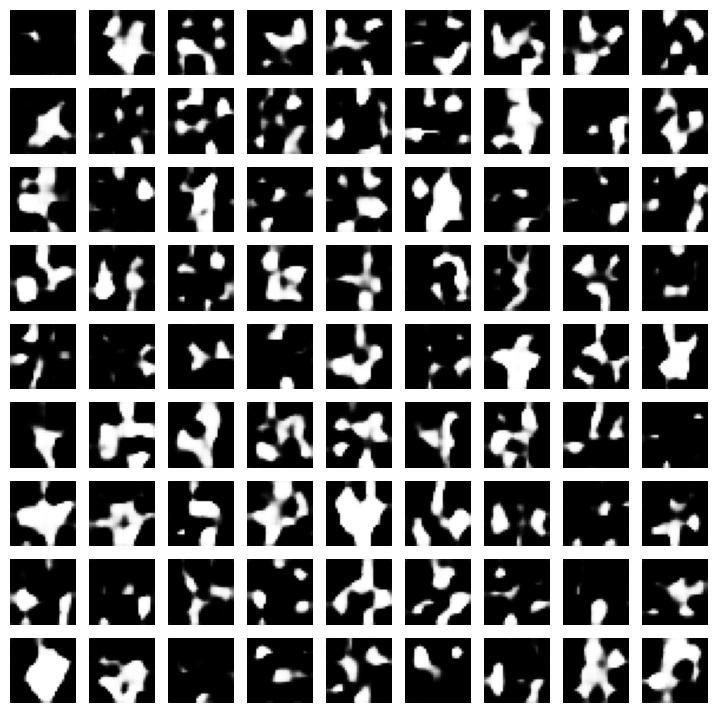

E:1, Loss G:3.2273, Loss D:0.0992, Acc G:%0.43, Acc D:%98.24
E:2, Loss G:3.0715, Loss D:0.1387, Acc G:%0.78, Acc D:%97.73


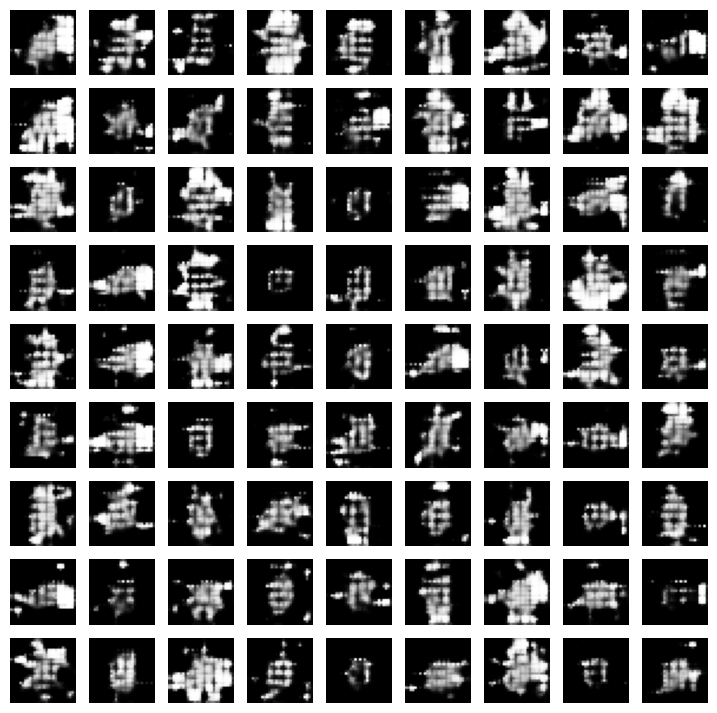

E:3, Loss G:2.4014, Loss D:0.2057, Acc G:%1.31, Acc D:%96.75
E:4, Loss G:1.9248, Loss D:0.3175, Acc G:%2.14, Acc D:%95.30


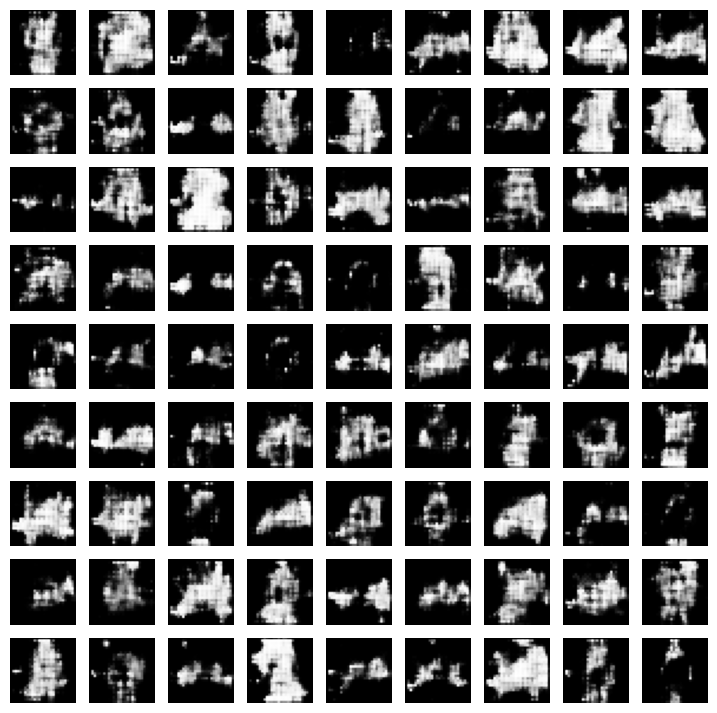

E:5, Loss G:1.9188, Loss D:0.2971, Acc G:%3.08, Acc D:%93.99
E:6, Loss G:1.8139, Loss D:0.3095, Acc G:%3.69, Acc D:%93.16


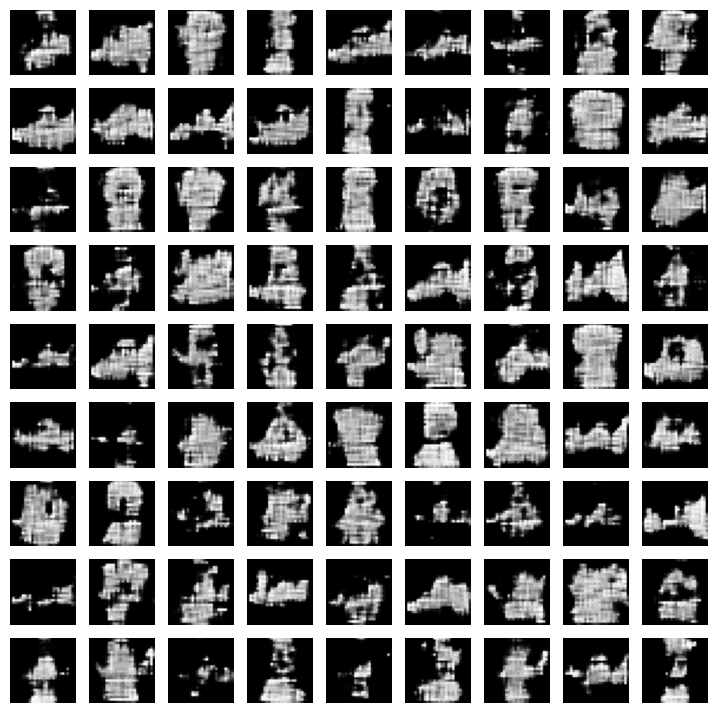

E:7, Loss G:1.7480, Loss D:0.3161, Acc G:%4.00, Acc D:%92.60
E:8, Loss G:1.7847, Loss D:0.3040, Acc G:%4.29, Acc D:%92.16


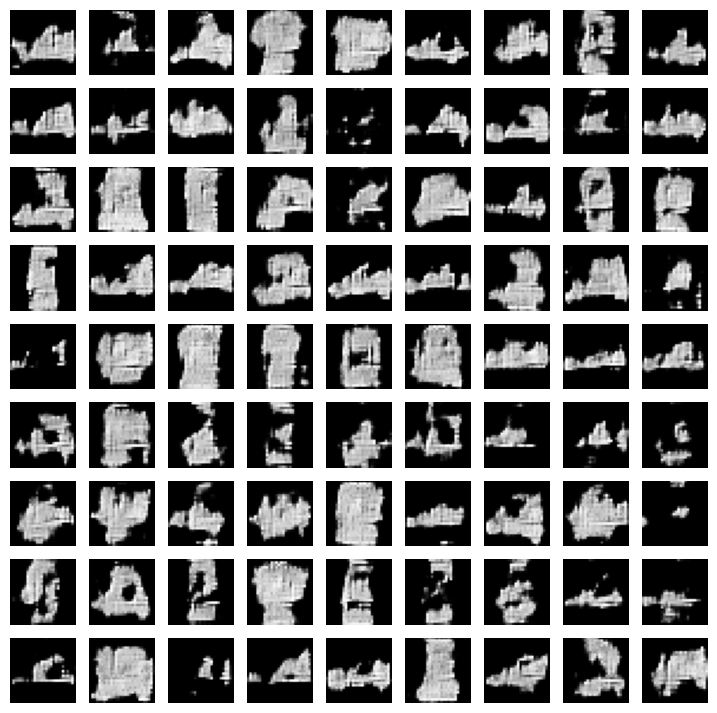

E:9, Loss G:1.8426, Loss D:0.2828, Acc G:%4.51, Acc D:%91.89


In [11]:
for epoch in range(10):

  # acumuladores para cálculo da média por época
  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  cnt = 0

  # percorre o dataset em batches
  for batch in dataset:

    # treina o discriminador
    dLoss = trainDStep(batch)
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']

    # treina o gerador
    gLoss = trainGStep(batch)
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    cnt += 1  # incrementa contador

  # exibe métricas da época
  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
      ))

  # gera imagens a cada 2 épocas
  if epoch % 2 == 0:
    plotImages(generator)


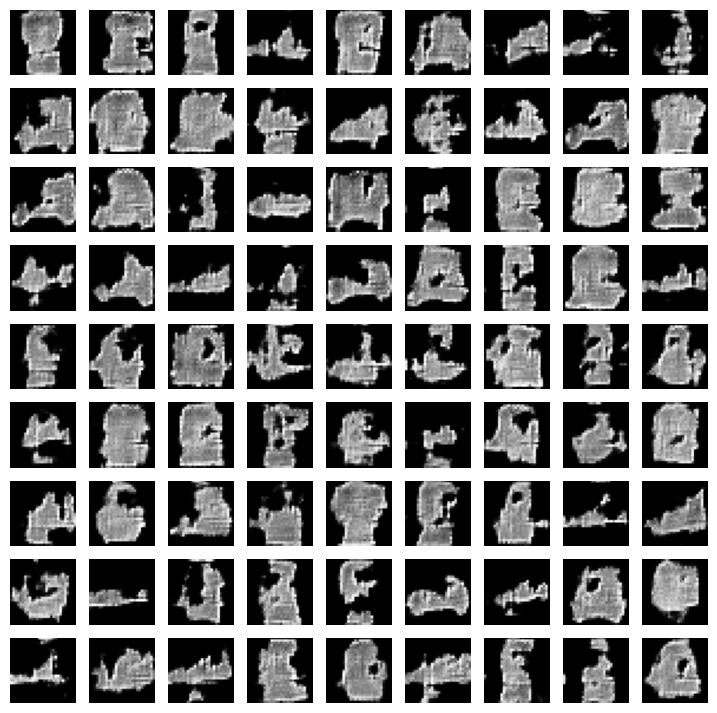

In [12]:
# gera imagens com o modelo treinado
images = generator(np.random.normal(size=(81, NOISE_DIM)))

plt.figure(figsize=(9, 9))

for i, image in enumerate(images):
    plt.subplot(9, 9, i+1)
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r")  # remove dimensões extras
    plt.axis('off')  # oculta eixos

plt.show()
